# Feature Engineering & Selection

**Goal**: Refine features based on granular event data, create interaction terms (breadth, tech vs social, sponsor hunters), and prepare the final dataset for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [2]:
# Load Data
df = pd.read_csv('../data/knight_hacks_dues_dataset_2025.csv')
print(f"Original Shape: {df.shape}")

Original Shape: (838, 40)


## 1. Missing Value Imputation
Handling missing values for the new granular event ratios and demographics.

In [ ]:
# Event Ratios -> 0
ratio_cols = [
    'gbm_ratio', 'social_ratio', 'hello_world_ratio', 'sponsorship_ratio', 
    'tech_exploration_ratio', 'class_support_ratio', 'workshop_ratio', 
    'ops_ratio', 'collabs_ratio'
]
for col in ratio_cols:
    df[col] = df[col].fillna(0)

# Ratings -> Mean
df['avg_event_rating_given'] = df['avg_event_rating_given'].fillna(df['avg_event_rating_given'].mean())

# Discord Days -> -1 (if not member)
df['discord_days_since_join'] = df['discord_days_since_join'].fillna(-1)

# Demographics -> 'Prefer not to answer'
df['gender'] = df['gender'].fillna('Prefer not to answer')
df['race_or_ethnicity'] = df['race_or_ethnicity'].fillna('Prefer not to answer')

# Target -> 0 (assume unpaid if missing)
df['y_paid_dues'] = df['y_paid_dues'].fillna(0)

## 2. Categorical Simplification
Grouping `school` (skewed) and `major` (into CS, IT, CE, Other).

In [ ]:
# School: UCF vs Other
def group_school(s):
    if pd.isna(s): return 'Other'
    if 'Central Florida' in s or 'UCF' in s: return 'UCF'
    return 'Other'

df['school_grouped'] = df['school'].apply(group_school)

# Major: CS, IT, CE, Other
def group_major(m):
    if pd.isna(m): return 'Other'
    m_lower = m.lower()
    if 'computer science' in m_lower:
        return 'Computer Science'
    elif 'information technology' in m_lower:
        return 'Information Technology'
    elif 'computer engineering' in m_lower:
        return 'Computer Engineering'
    else:
        return 'Other'

df['major_grouped'] = df['major'].apply(group_major)
print("Major Distribution:\n", df['major_grouped'].value_counts())

Major Distribution:
 major_grouped
Computer Science          760
Other                      33
Information Technology     26
Computer Engineering       19
Name: count, dtype: int64


## 3. Numerical Feature Engineering & Interactions

In [ ]:
# Discord Active Flag
df['is_discord_active'] = (df['discord_msgs_year'] > 0).astype(int)

# Engagement Breadth
# Count of distinct event TYPES attended
event_type_cols = [
    'n_gbm_year', 'n_social_year', 'n_hello_world_year', 'n_sponsorship_year',
    'n_tech_exploration_year', 'n_class_support_year', 'n_workshop_year',
    'n_ops_year', 'n_collabs_year'
]
df['engagement_breadth'] = df[event_type_cols].gt(0).sum(axis=1)

# Tech vs Social Score
# Tech: Workshops, Collabs, Hello World, Tech Exploration, Class Support
# Social: Socials, GBM
df['tech_score'] = (
    df['n_workshop_year'] + 
    df['n_collabs_year'] + 
    df['n_hello_world_year'] + 
    df['n_tech_exploration_year'] + 
    df['n_class_support_year']
)

df['social_score'] = df['n_social_year'] + df['n_gbm_year']

# Tech/Social Ratio (add 1 to den to handle 0 social)
df['tech_social_ratio'] = df['tech_score'] / (df['social_score'] + 1)

# 3.4 Sponsor Hunter Flag
# Someone who attends >0 sponsorship events and they make up >= 80% of their total events
def check_sponsor_hunter(row):
    if row['n_sponsorship_year'] == 0 or row['events_attended_year'] == 0:
        return 0
    ratio = row['n_sponsorship_year'] / row['events_attended_year']
    return 1 if ratio >= 0.8 else 0

df['is_sponsor_hunter'] = df.apply(check_sponsor_hunter, axis=1)

print("Sponsor Hunters Found:", df['is_sponsor_hunter'].sum())

Sponsor Hunters Found: 37


## 4. Feature Selection & Cleanup
Dropping noise and raw columns. Keeping `major_grouped` and `class`.

In [6]:
drop_cols = [
    'discordUser', 'school', 'level_of_study', 'major', 'gender', 'race_or_ethnicity',
    'social_ratio', 'workshop_ratio', 'sponsorship_ratio', 
    'hello_world_ratio', 'tech_exploration_ratio', 'collabs_ratio', 'gbm_ratio'
]

print("Columns:", df.columns)

# Add duplicate/old columns to drop list if they exist
if 'level_of_study' in df.columns:
    drop_cols.append('level_of_study')

# Ensure we don't try to drop columns that aren't there
existing_drop = [c for c in drop_cols if c in df.columns]
df_clean = df.drop(columns=existing_drop)

print(f"Cleaned Shape: {df_clean.shape}")
df_clean.head()

Columns: Index(['discordUser', 'member_days_since_join', 'events_attended_year',
       'distinct_event_days_year', 'attendance_streak_weeks', 'n_gbm_year',
       'gbm_ratio', 'n_social_year', 'social_ratio', 'n_hello_world_year',
       'hello_world_ratio', 'n_sponsorship_year', 'sponsorship_ratio',
       'n_tech_exploration_year', 'tech_exploration_ratio',
       'n_class_support_year', 'class_support_ratio', 'n_workshop_year',
       'workshop_ratio', 'n_ops_year', 'ops_ratio', 'n_collabs_year',
       'collabs_ratio', 'feedback_count_year', 'avg_event_rating_given',
       'left_any_feedback', 'has_gone_to_hackathon', 'discord_member',
       'discord_days_since_join', 'has_role_ops', 'discord_msgs_year',
       'discord_active_days_year', 'discord_channels_posted_year',
       'discord_num_roles', 'class', 'major', 'school', 'gender',
       'race_or_ethnicity', 'y_paid_dues', 'school_grouped', 'major_grouped',
       'is_discord_active', 'engagement_breadth', 'tech_score', 'soc

,member_days_since_join,events_attended_year,distinct_event_days_year,attendance_streak_weeks,n_gbm_year,n_social_year,n_hello_world_year,n_sponsorship_year,n_tech_exploration_year,n_class_support_year,class_support_ratio,n_workshop_year,n_ops_year,ops_ratio,n_collabs_year,feedback_count_year,avg_event_rating_given,left_any_feedback,has_gone_to_hackathon,discord_member,discord_days_since_join,has_role_ops,discord_msgs_year,discord_active_days_year,discord_channels_posted_year,discord_num_roles,class,y_paid_dues,school_grouped,major_grouped,is_discord_active,engagement_breadth,tech_score,social_score,tech_social_ratio,is_sponsor_hunter
0,84,0,0,0,0,0,0,0,0,0,0.000,0,0,0.000000,0,0,9.084256,0,0,1,1177.0,0,0,0,0,12,Senior,1,UCF,Computer Science,0,0,0,0,0.000000,0
1,74,6,6,3,0,1,0,0,0,0,0.000,0,5,0.833333,0,0,9.084256,0,1,1,142.0,1,1594,45,9,18,Freshman,1,UCF,Computer Science,1,2,0,1,0.000000,0
2,64,0,0,0,0,0,0,0,0,0,0.000,0,0,0.000000,0,0,9.084256,0,1,1,443.0,0,0,0,0,7,Sophomore,1,UCF,Computer Science,0,0,0,0,0.000000,0
3,308,8,13,9,2,0,0,0,0,1,0.125,0,5,0.625000,0,0,9.084256,0,1,1,449.0,1,3328,161,13,15,Sophomore,1,UCF,Computer Science,1,3,1,2,0.333333,0
4,308,4,8,3,1,0,0,0,1,2,0.500,0,0,0.000000,0,0,9.084256,0,1,1,414.0,0,2,1,1,5,Junior,1,UCF,Computer Science,1,3,3,1,1.500000,0


## 5. Export

In [7]:
output_path = '../data/knight_hacks_dues_processed.csv'
df_clean.to_csv(output_path, index=False)
print(f"Saved processed data to {output_path}")

Saved processed data to ../data/knight_hacks_dues_processed.csv


## 6. Engineered Feature Analysis (Validation)

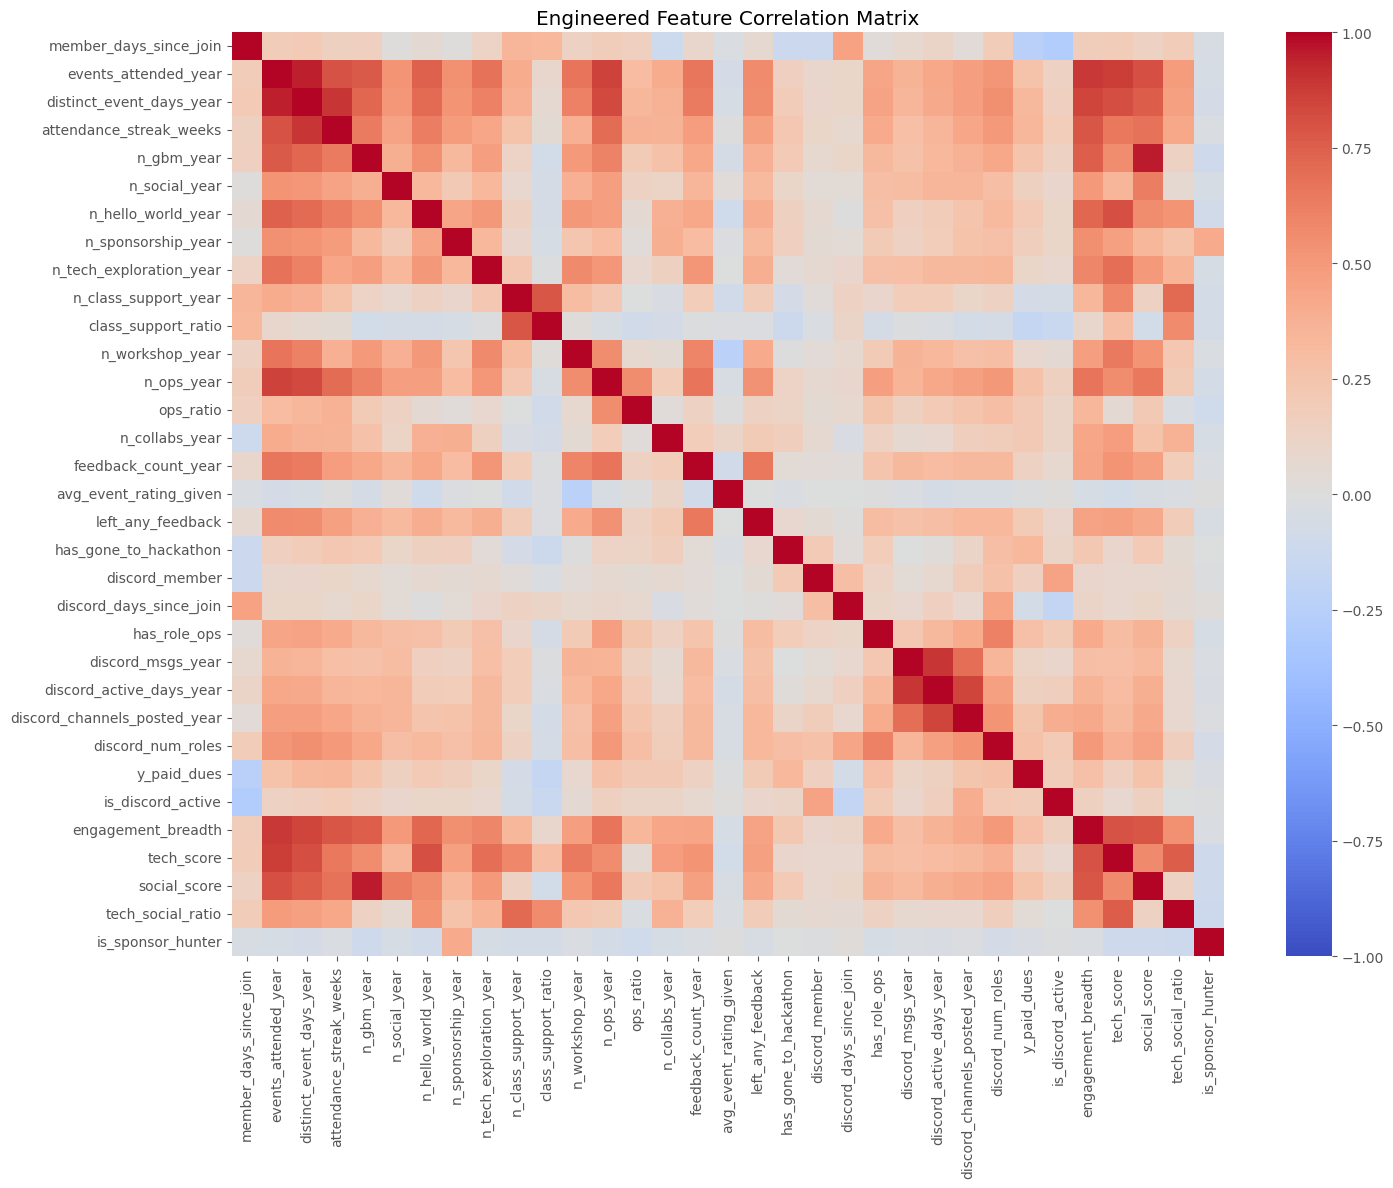

Top Positive Correlations:
 attendance_streak_weeks         0.338341
has_gone_to_hackathon           0.332712
distinct_event_days_year        0.321842
engagement_breadth              0.280154
has_role_ops                    0.276730
discord_num_roles               0.272789
n_ops_year                      0.267069
events_attended_year            0.264785
social_score                    0.262453
n_gbm_year                      0.257221
discord_channels_posted_year    0.246623
ops_ratio                       0.218418
n_collabs_year                  0.217229
n_hello_world_year              0.206544
left_any_feedback               0.195973
Name: y_paid_dues, dtype: float64

Top Negative Correlations:
 discord_msgs_year          0.119671
n_tech_exploration_year    0.106210
n_workshop_year            0.081268
tech_social_ratio          0.042573
avg_event_rating_given    -0.010911
is_sponsor_hunter         -0.038359
n_class_support_year      -0.069275
discord_days_since_join   -0.071264
class_

In [ ]:
# Correlation Analysis
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Engineered Feature Correlation Matrix')
plt.show()

# Top Correlations
target_corr = corr_matrix['y_paid_dues'].drop('y_paid_dues').sort_values(ascending=False)
print("Top Positive Correlations:\n", target_corr.head(15))
print("\nTop Negative Correlations:\n", target_corr.tail(10))

/home/dvidal1205/Dropbox/School Documents/Spring 2025/ISC 4241/final-project/.venv/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [13:15:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


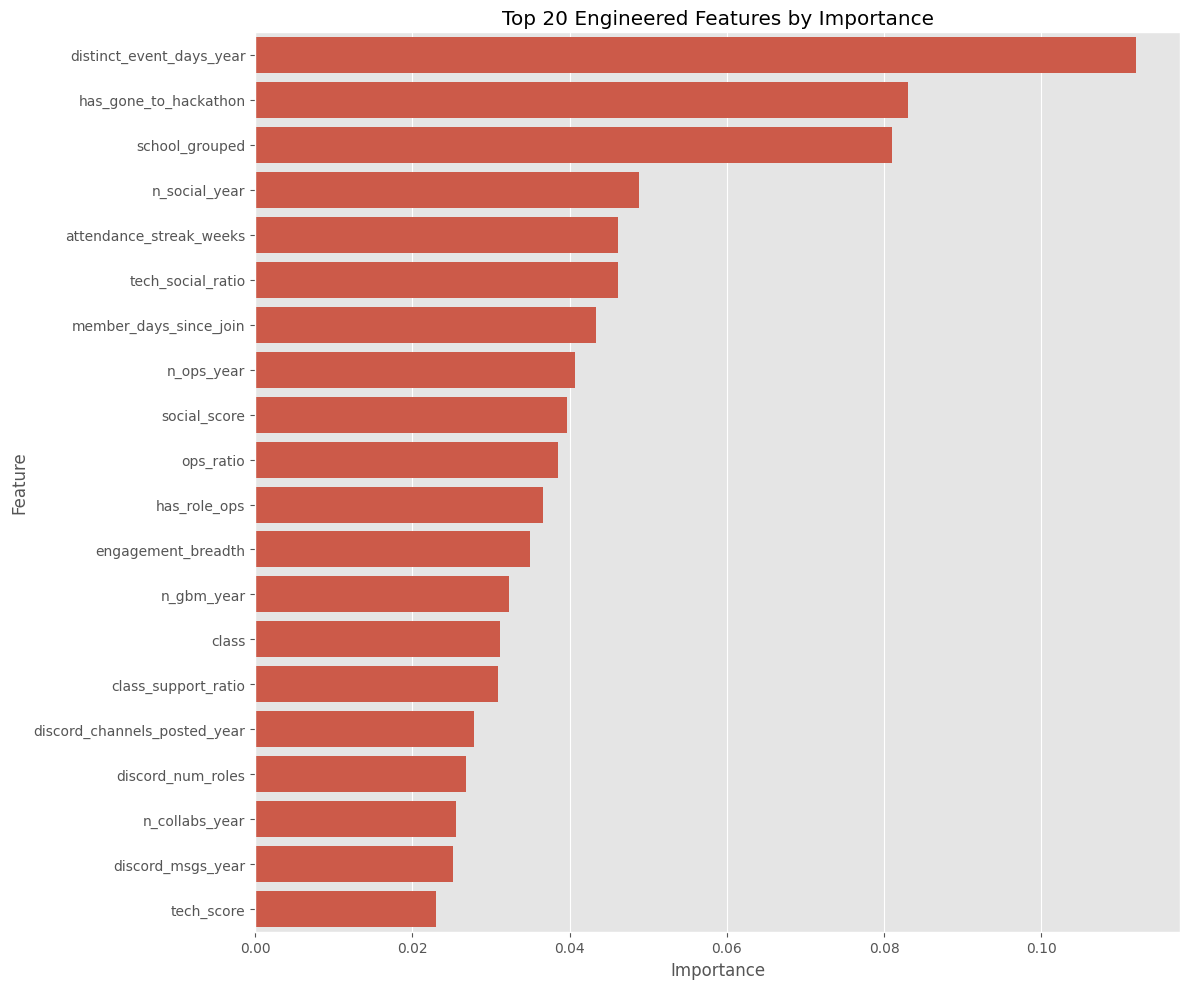

In [9]:
# Feature Importance (XGBoost on Engineered Data)
X = df_clean.drop('y_paid_dues', axis=1)
y = df_clean['y_paid_dues']

# Encode Categoricals
X_encoded = X.copy()
cat_cols = X_encoded.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Train Model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_encoded, y)

# Plot Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Engineered Features by Importance')
plt.tight_layout()
plt.show()

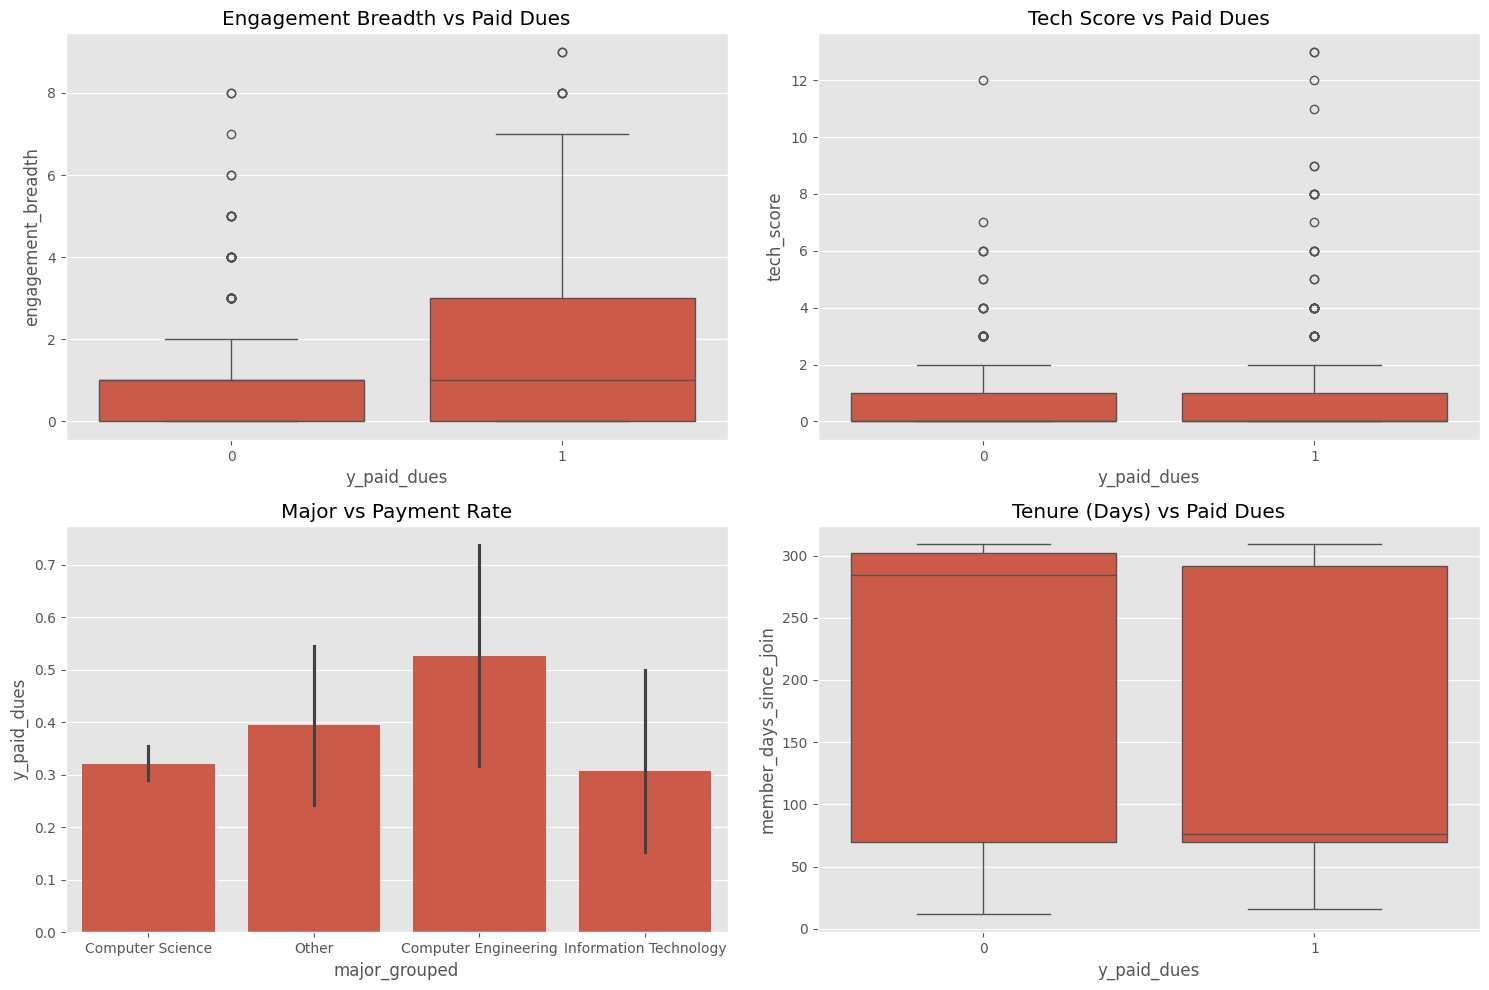

In [10]:
# Visualize Key Interactions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(x='y_paid_dues', y='engagement_breadth', data=df_clean, ax=axes[0,0])
axes[0,0].set_title('Engagement Breadth vs Paid Dues')

sns.boxplot(x='y_paid_dues', y='tech_score', data=df_clean, ax=axes[0,1])
axes[0,1].set_title('Tech Score vs Paid Dues')

sns.barplot(x='major_grouped', y='y_paid_dues', data=df_clean, ax=axes[1,0])
axes[1,0].set_title('Major vs Payment Rate')

sns.boxplot(x='y_paid_dues', y='member_days_since_join', data=df_clean, ax=axes[1,1])
axes[1,1].set_title('Tenure (Days) vs Paid Dues')

plt.tight_layout()
plt.show()